In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from xml.etree.ElementTree import parse
from IPython.display import display

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import utils

In [2]:
num_classes = 29 + 1

def get_object_detection_model(num_classes):
    # load an object_detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained box_predictor with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device :", device)

device : cuda


In [3]:
class_dict = {"background":0, "naengmyeon":1, "bibimbap":2, "samgyetang":3, "yukgaejang":4, "galbijjim":5, "ddukguk":6, "sundae":7, \
              "jokbal":8, "japchae":9, "bindaetteok":10, "udon":11, "tonkatsu":12, "soba":13, "gyudon":14, "ramen":15, "okonomiyaki":16, \
              "jajangmyeon":17, "jjambbong":18, "tangsuyuk":19, "beijingduck":20, "mapotofu":21, "shaolongbao":22, \
              "hamburger":23, "margeritapizza":24, "friedchicken":25, "curryrice":26, "fishandchips":27, "tomyamkung":28, \
              "nasigoreng":29}

class FoodetectorDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annos = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        # load images and annotations
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        anno_path = os.path.join(self.root, "annotations", self.annos[idx])
        img = Image.open(img_path).convert("RGB")
        
        # get bounding box coordinates from annotation
        tree = parse(anno_path)
        
        objects = tree.getroot().findall("object")
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(class_dict[label])
            bndbox = obj.find('bndbox')
            xmin, ymin = int(bndbox.find('xmin').text), int(bndbox.find('ymin').text) 
            xmax, ymax = int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
        
        #size = tree.getroot().find("size")
        #width = size.find("width").text
        #height = size.find("height").text
        #channels = size.find("depth").text
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
# model LOAD
model = get_object_detection_model(num_classes)
model.load_state_dict(torch.load("data/models/foodetector_v1.model"))
model.to(device)
model.eval()
pass

In [5]:
# Test Dataset evaluation 결과 분석
class_name = list(class_dict.keys())

with open('test_data.pkl', 'rb') as file:
    dataset_test = pickle.load(file)
    
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

model.eval()
pred_y = []  # predicted class
real_y = []  # real class
missed = []  # index of wrong answers (첫번째 object에 한함)
success = []  # index of right answers (첫번째 object에 한함)
cm = np.zeros((30,30))  # confusion matrix
for j in range(len(dataset_test)):
    img, info = dataset_test[j]
    with torch.no_grad():
        prediction = model([img.to(device)])
    if len(prediction[0]['labels']) == 0:
        continue

    pred_y.append(prediction[0]['labels'][0].item())
    real_y.append(info['labels'][0].item())
    cm[real_y[-1], pred_y[-1]] += 1
    
    if real_y[-1] != pred_y[-1]:
        missed.append(j)
    elif prediction[0]['scores'][0].item() > 0.9:
        success.append(j)

/home/bumsuk/test/venv/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


errors by real classes
 [0. 1. 1. 1. 1. 3. 0. 1. 1. 0. 2. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 1.]
errors by predicted classes
 [0. 0. 0. 1. 4. 0. 1. 0. 0. 0. 0. 0. 0. 0. 4. 1. 0. 0. 1. 0. 0. 3. 0. 0.
 0. 3. 2. 0. 1. 2.]
['galbijjim', 'tomyamkung']


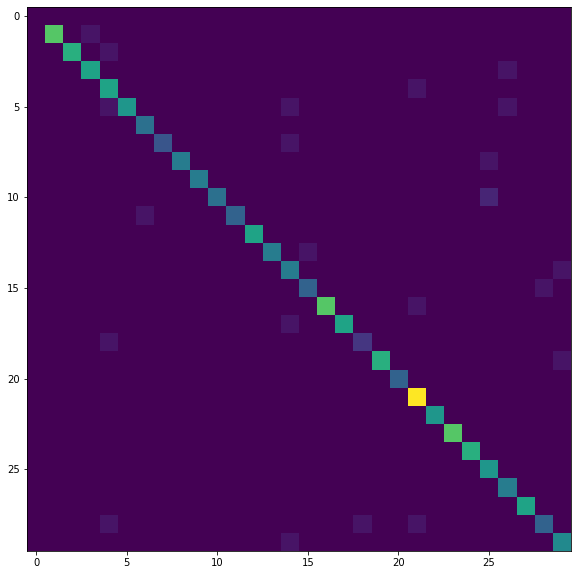

In [6]:
# confusion matrix 시각화
# cm: confusion matrix, cm_edit: 틀린 부분만 표시
cm_edit = cm.copy()
for i in range(30):
    cm_edit[i,i] = 0

plt.figure(figsize=(10,10))
plt.imshow(cm)

print("errors by real classes\n", np.sum(cm_edit, axis=1))
print("errors by predicted classes\n", np.sum(cm_edit, axis=0))
print([class_name[i] for i in np.where(np.sum(cm_edit, axis=1)>2)[0]])

In [7]:
# Test Dataset 중 첫번째 object 틀린 갯수
len(missed)

23

In [ ]:
# 필요시 confusion matrix *.csv로 저장
# np.savetxt('20_cm.csv', cm, delimiter=',', fmt='%s')

In [8]:
def draw_bbox(idx):
    img, info = dataset_test[idx]

    with torch.no_grad():
        prediction = model([img.to(device)])

    imgx = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

    img1 = ImageDraw.Draw(imgx)
    for i in range(len(prediction[0]['labels'])):
        if prediction[0]['scores'][i] > 0.5: # score 0.5 이상 보여주기
            box = prediction[0]['boxes'][i]
            img1.rectangle((box[0], box[1], box[2], box[3]), outline ='yellow')
            img1.text((box[0], box[1]), class_name[int(prediction[0]['labels'][i])]+" "+str(prediction[0]['scores'][i]), fill='yellow')
            print(info['labels'][0].item(), class_name[info['labels'][0].item()], prediction[0]['labels'][i].item(), \
                  class_name[prediction[0]['labels'][i].item()], prediction[0]['scores'][i].item())
    display(imgx)

In [ ]:
# 틀린 그림 전체 확인하기
# 저장 전 output 삭제
for i in range(len(missed)):
    draw_bbox(missed[i])

7 sundae 14 gyudon 0.8871353268623352


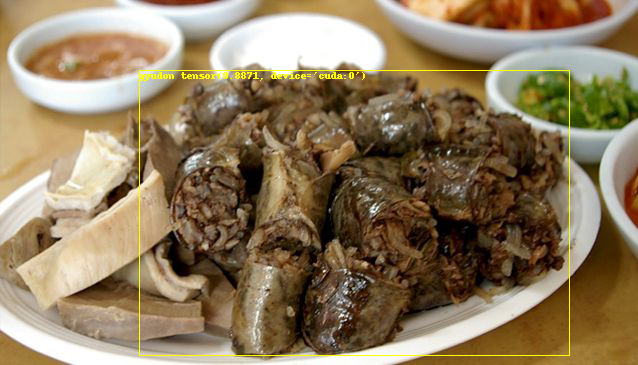

In [11]:
# 틀린 그림 중 랜덤으로 하나씩 확인하기 (Ctrl+Enter)
i = np.random.randint(len(missed))
draw_bbox(missed[i])

27 fishandchips 27 fishandchips 0.9478349089622498


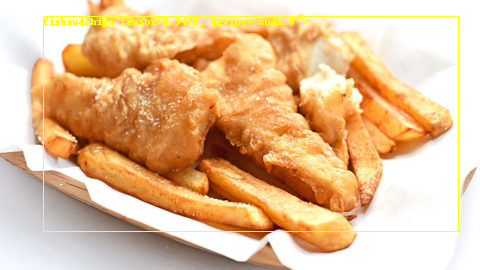

In [12]:
# 맞은 그림 중 랜덤으로 하나씩 확인하기 (Ctrl+Enter)
i = np.random.randint(len(success))
draw_bbox(success[i])